# Stress Analyze

In [ ]:
import os
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict

import nltk
from nltk.corpus import stopwords, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

import pickle

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Data Preprocessing
- Tokenization & Remove punctuation.
- Removal of commonly used word (stopword).
- Stemming (Normalization).
- Lammatization (Normalization).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset/'
train = pd.read_csv(f'{path}dreaddit-train.csv', encoding = 'ISO-8859-1')
test = pd.read_csv(f'{path}dreaddit-test.csv', encoding = 'ISO-8859-1')

### Tokenization & Remove punctuation

In [ ]:
# Regex
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [ ]:
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

### Stemming

In [ ]:
stemmer = PorterStemmer()

def word_stemmer(text):
  stem_word = [stemmer.stem(i) for i in text]
  return stem_word

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

### Lammatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def word_lammatizer(text):
  lem_word = [lemmatizer.lemmatize(i) for i in text]
  return lem_word

train['processed_text'] = train['processed_text'].apply(lambda x: word_lammatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lammatizer(x))

In [ ]:
# for elem in train['processed_text']:
#   print(elem)

## Feature Extraction

### Word2Vec + TF-IDF

In [ ]:
word2vec = Word2Vec(train['processed_text'],
                    size = 300,
                    window = 10,
                    min_count = 1,
                    workers = 10,
                    iter = 100)

In [ ]:
pickle_output = open('word_model.pkl', 'wb')
pickle.dump(word2vec, pickle_output)
pickle_output.close()

In [ ]:
print(word2vec.wv.vector_size)

300


In [ ]:
semantically_similar_words = {words: [item[0] for item in word2vec.wv.most_similar([words], topn = 5)] 
                for words in ['abus', 'anxieti', 'financ', 'ptsd', 'social', 'stress', 'love', 'friendship']}

In [ ]:
for k, v in semantically_similar_words.items():
  print(f'{k}:{str(v)}')

abus:['revert', 'erod', 'transpar', 'mistreat', 'victim']
anxieti:['lexapro', 'prescrib', 'bipolar', 'mood', 'symptom']
financ:['statur', 'util', 'wage', 'unfourtunatley', 'instal']
ptsd:['jett', 'raffl', 'traumat', 'disord', 'borderlin']
social:['medium', 'enviou', 'uninstal', 'interact', 'doug']
stress:['everyday', 'sympthom', 'reflux', 'statur', 'throw']
love:['sweet', 'platon', 'fun', 'beauti', 'passion']
friendship:['jessi', 'lisa', 'sassi', 'handl', 'beyond']


In [ ]:
# similarity of 2 words
print(word2vec.wv.similarity(w1 = 'love', w2 = 'anxieti'))

-0.025805427


In [ ]:
keys = ['abus', 'anxieti', 'financ', 'ptsd', 'social']
word_clusters = []
embedding_clusters = []

for word in keys:
  embeddings = []
  words = []
  for similar_word, _ in word2vec.wv.most_similar(word, topn = 20):
    words.append(similar_word)
    embeddings.append(word2vec[similar_word])
  word_clusters.append(words)
  embedding_clusters.append(embeddings)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity = 15,
                        n_components = 2, 
                        init = 'pca',
                        n_iter = 3500, 
                        random_state = 32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

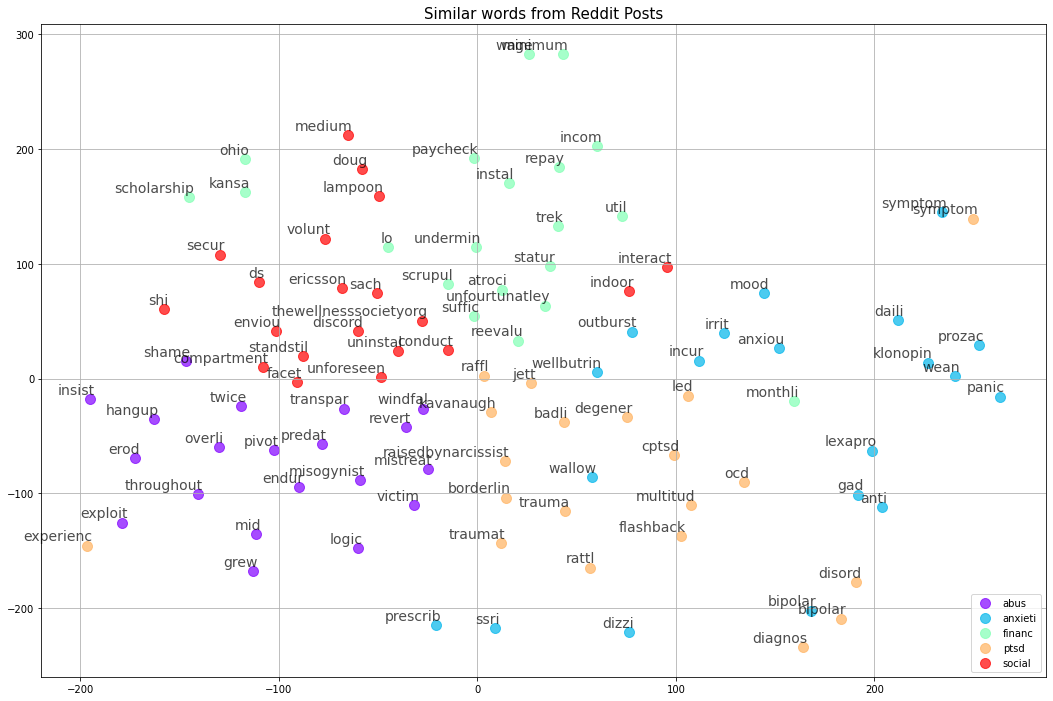

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(18, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, s=100, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4)
    plt.title(title, size=15)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_similar_words('Similar words from Reddit Posts', keys, embeddings_en_2d, word_clusters, 0.7)

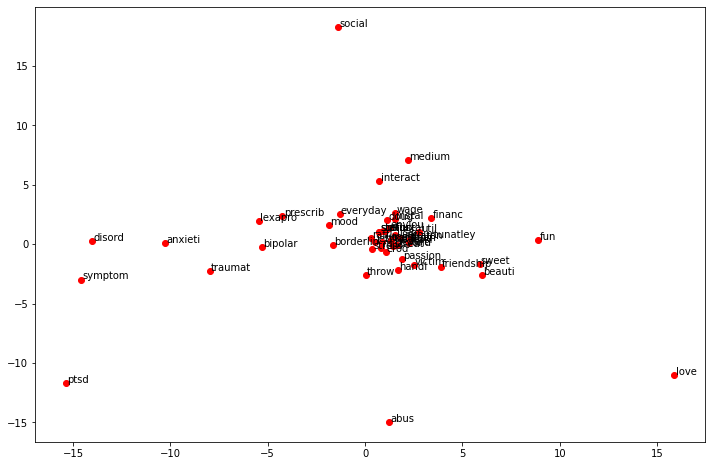

In [ ]:
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])
word_vectors = word2vec.wv[all_similar_words]
pca = PCA(n_components=2)
p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words
plt.figure(figsize=(12, 8))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [ ]:
class TfidfEmbeddingVectorizer(object):
  
    def __init__(self, word_model):
        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
        :param: pre_processed_docs: list of docs, which are tokenized
        :return: self
        """
        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer() # default 1-gram 
        tfidf.fit(text_docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,
                                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector

    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """
        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean

    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [ ]:
pickle_output = open('word_vectorizer.pkl', 'wb')
pickle.dump(TfidfEmbeddingVectorizer, pickle_output)
pickle_output.close()

In [ ]:
train_token = train['processed_text']
test_token = test['processed_text']

X = train_token.append(test_token)
X = X.reset_index(drop=True)

In [ ]:
tfidf_vec_tr = TfidfEmbeddingVectorizer(word2vec)

# fit tfidf model
tfidf_vec_tr.fit(X)
tfidf_doc_vec = tfidf_vec_tr.transform(X)

## Classification

### Word Embedding + TF-IDF

In [ ]:
scaler = StandardScaler()
tfidf_doc_vec_scaled = scaler.fit_transform(tfidf_doc_vec)

In [ ]:
X_train = tfidf_doc_vec[:len(train)]
y_train = train['label']

X_test = tfidf_doc_vec[len(train):]
y_test = test['label']

In [ ]:
clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'sgd classifier': SGDClassifier(random_state=42),
            'ada boost': AdaBoostClassifier(n_estimators=100, random_state=42),
            'gradient boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'KNN': KNeighborsClassifier()}

In [ ]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of log reg: 0.7496503496503496
Accuracy of naive bayes: 0.6503496503496503
Accuracy of linear svc: 0.7342657342657343
Accuracy of sgd classifier: 0.676923076923077
Accuracy of ada boost: 0.6853146853146853
Accuracy of gradient boosting: 0.7342657342657343
Accuracy of CART: 0.6405594405594406
Accuracy of random forest: 0.7146853146853147
Accuracy of KNN: 0.6559440559440559


#### Evaluate log reg

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7496503496503496

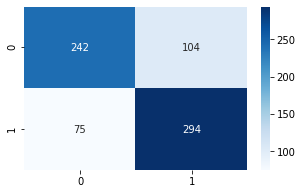

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.7386934673366834
Recall 0.7967479674796748
F1-Score 0.7666232073011734


#### Evaluate radom forest

In [ ]:
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7202797202797203

In [ ]:
pickle_output = open('word_embedding_rf.pkl', 'wb')
pickle.dump(clf, pickle_output)
pickle_output.close()

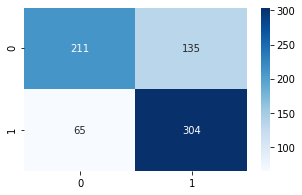

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.6924829157175398
Recall 0.8238482384823849
F1-Score 0.7524752475247525


# Stress Analyze for serving

In [ ]:
# Data preprocessing
from tqdm import tqdm

class Posts:
    def __init__(self, text_df):
        self.text_df = text_df
        return

    def tokenization(self):
        tqdm.pandas()
        tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
        tokens_df = self.text_df.progress_apply(lambda x: tokenizer.tokenize(x.lower()))
        return tokens_df

    def remove_stopwords(self, tokens):
        words = [w for w in tokens if w not in stopwords.words('english')]
        return words

    def word_lemmatizer(self, tokens):
        lemmatizer = WordNetLemmatizer()
        lem_text = [lemmatizer.lemmatize(i) for i in tokens]
        return lem_text

    def preprocess(self):
        tokens = self.tokenization()
        tokens_sw = tokens.progress_apply(lambda x: self.remove_stopwords(x))
        final_tokens = tokens_sw.progress_apply(lambda x: self.word_lemmatizer(x))
        return final_tokens

In [ ]:
# Word2Vec + TF-IDF
from collections import defaultdict
from gensim.test.utils import common_texts

class WordEmbeddingVectorizer(object):
    def __init__(self, word_model):
        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, texts):
        text_docs = []
        for text in texts:
            text_docs.append(" ".join(text))

        tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
        tfidf.fit(text_docs)
        max_idf = max(tfidf.idf_)
        self.word_idf_weight = defaultdict(lambda: max_idf,
                                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, texts):
        text_word_vector = self.word_average_list(texts)
        return text_word_vector

    def word_average(self, sent):
        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])

        if not mean:
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean

    def word_average_list(self, docs):
        return np.vstack([self.word_average(sent) for sent in docs])

In [ ]:
def preprocess(series):
  preprocess_series = Posts(series).preprocess()
  print(preprocess_series)
  word_embedding_rf = WordEmbeddingVectorizer(word2vec)
  input_matrix = word_embedding_rf.fit(preprocess_series).transform(preprocess_series)
  return input_matrix

In [ ]:
def predict(series):
  input_matrix = preprocess(pd.Series(series))
  pred_labels = clf.predict(input_matrix)
  print(pred_labels)
  pred_proba = clf.predict_proba(input_matrix)
  print(pred_proba)
  confidence_score = [prob[1] for prob in pred_proba]
  output = pd.DataFrame({'text': series, 'confidence_score': confidence_score, 'labels': pred_labels})
  output['labels'] = output['labels'].map({1: 'stress', 0: 'non-stress'})
  return output

In [ ]:
predict(["I am very happy today", "It's friday, wish you have a nice weekend", "I feel bad since yesterday", "I feel happy today", "I am unhappy today"])

100%|██████████| 5/5 [00:00<00:00, 3391.80it/s]

0                   [happy, today]
1    [friday, wish, nice, weekend]
2    [feel, bad, since, yesterday]
3             [feel, happy, today]
4                 [unhappy, today]
dtype: object
[0 0 1 1 0]
[[0.58 0.42]
 [0.74 0.26]
 [0.24 0.76]
 [0.36 0.64]
 [0.58 0.42]]


,text,confidence_score,labels
0,I am very happy today,0.42,non-stress
1,"It's friday, wish you have a nice weekend",0.26,non-stress
2,I feel bad since yesterday,0.76,stress
3,I feel happy today,0.64,stress
4,I am unhappy today,0.42,non-stress
